In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from timeit import default_timer as timer

random_seed = 0
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if you are using multi-GPU.
np.random.seed(random_seed)
g = torch.Generator()
g.manual_seed(random_seed)
#https://github.com/pytorch/pytorch/issues/7068
#https://discuss.pytorch.org/t/random-seed-initialization/7854/28
#https://pytorch.org/docs/stable/notes/randomness.html

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28*28, 500)  # 28*28 from image dimension 
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
if torch.cuda.is_available():
  net = net.cuda()

print(net)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=5, bias=True)
)


In [4]:
def data_loader(batch_size, n_workers):
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    #test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    label = [1, 2, 3 ,4, 6]
    data_fea = np.array(train_data_th.data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_fea = (data_fea / 255)
    data_gnd = np.array(train_data_th.targets)
    ctr1_idx = np.where(data_gnd[:] == label[0])
    ctr2_idx = np.where(data_gnd[:] == label[1])
    ctr3_idx = np.where(data_gnd[:] == label[2])
    ctr4_idx = np.where(data_gnd[:] == label[3])
    ctr6_idx = np.where(data_gnd[:] == label[4])
    ctr1_idx = np.array(ctr1_idx)
    ctr1_idx = ctr1_idx[0,0:1500]
    ctr2_idx = np.array(ctr2_idx)
    ctr2_idx = ctr2_idx[0,0:1500]
    ctr3_idx = np.array(ctr3_idx)
    ctr3_idx = ctr3_idx[0,0:1500]
    ctr4_idx = np.array(ctr4_idx)
    ctr4_idx = ctr4_idx[0,0:1500]
    ctr6_idx = np.array(ctr6_idx)
    ctr6_idx = ctr6_idx[0,0:1500]
    train_idx = np.concatenate((ctr1_idx[:500], ctr2_idx[:500], ctr3_idx[:500], ctr4_idx[:500], ctr6_idx[:500]),axis = None)
    validation_idx = np.concatenate((ctr1_idx[500:1000], ctr2_idx[500:1000], ctr3_idx[500:1000], ctr4_idx[500:1000], ctr6_idx[500:1000]),axis = None)
    test_idx = np.concatenate((ctr1_idx[1000:1500], ctr2_idx[1000:1500], ctr3_idx[1000:1500], ctr4_idx[1000:1500], ctr6_idx[1000:1500]),axis = None)

    data_train = data_fea[train_idx]
    target_train = data_gnd[train_idx]

    data_validation = data_fea[validation_idx]
    target_validation = data_gnd[validation_idx]

    data_test = data_fea[test_idx]
    target_test = data_gnd[test_idx]

    ##not sure what this is doing but it was here in the og
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_validation -=dtrain_mean
    data_test -= dtrain_mean
    ##

    #######
    #https://discuss.pytorch.org/t/indexerror-target-2-is-out-of-bounds/69614/24 I AM SO HAPPY I FOUND THIS FORUM!
    tensor_target_train = torch.from_numpy(target_train)
    # print(tensor_target_train.size())
    # print(min(tensor_target_train))
    # print(max(tensor_target_train))
    unique_targets_train = torch.unique(tensor_target_train)
    # print('unique_targets_train: {}'.format(unique_targets_train))

    new_tensor_target_train = torch.empty_like(tensor_target_train)
    for idx, t in enumerate(unique_targets_train):
        # print('replacing {} with {}'.format(t, idx))
        new_tensor_target_train[tensor_target_train == t] = idx
    # print(new_tensor_target_train.size())
    # print(min(new_tensor_target_train))
    # print(max(new_tensor_target_train))

    tensor_target_validation = torch.from_numpy(target_validation)
    unique_targets_validation = torch.unique(tensor_target_validation)
    new_tensor_target_validation = torch.empty_like(tensor_target_validation)
    for idx, t in enumerate(unique_targets_validation):
      new_tensor_target_validation[tensor_target_validation == t] = idx

    tensor_target_test = torch.from_numpy(target_test)
    unique_targets_test = torch.unique(tensor_target_test)
    new_tensor_target_test = torch.empty_like(tensor_target_test)
    for idx, t in enumerate(unique_targets_test):
      new_tensor_target_test[tensor_target_test == t] = idx

    #new size of dataset is 2500
    train_data = TensorDataset(torch.from_numpy(data_train), new_tensor_target_train)
    validation_data = TensorDataset(torch.from_numpy(data_validation), new_tensor_target_validation)
    test_data = TensorDataset(torch.from_numpy(data_test), new_tensor_target_test)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True,worker_init_fn=seed_worker,generator=g)
    validation_loader = DataLoader(validation_data, num_workers = n_workers, batch_size = batch_size, shuffle = True,worker_init_fn=seed_worker,generator=g)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False,worker_init_fn=seed_worker,generator=g)

    return train_loader, validation_loader, test_loader

In [5]:
def calc_acc(loader, net):
    correct_cnt = 0
    total_cnt = 0
    #net.eval()
    with torch.no_grad():
        for batch_inputs, batch_labels in loader:
            if torch.cuda.is_available():
                batch_inputs = batch_inputs.cuda()
                batch_labels = batch_labels.cuda()
            out = net(batch_inputs)
            _, pred_labels = torch.max(out.data, 1)
            total_cnt += batch_labels.size(0)
            correct_cnt += (pred_labels == batch_labels).sum().item()

    return correct_cnt / total_cnt


In [6]:
plotval = []
plottrain = []
plotdiftrainval = []
plotepoch = []
plotloss = []
avg_loss = []
timetaken = []

In [7]:
# batch_size_init = 2048
# n_workers_init = 2
# train_loader, validation_loader, test_loader = data_loader(batch_size_init, n_workers_init)

In [8]:
# print("Before optimizing the model")
# print(f'train accurary: {100 * calc_acc(train_loader,net):.3f}%')
# print(f'validation accurary: {100 * calc_acc(validation_loader,net):.3f}%')
# print(f'test accurary: {100 *calc_acc(test_loader,net):.3f}%')

In [9]:
nnloss = torch.nn.CrossEntropyLoss()
from torch import nn, optim

#I optimized lr, momentum, weight_decay, batch, epoch, step_size, and gamma
#values are seen in the code blocks below

# def train_net(i):
#     net = Net()
#     if torch.cuda.is_available():
#         net = net.cuda()
#     # Your task is to choose best parameters of optimization (momentum, batch size, learning rate, l2 regularization).
#     params = list(filter(lambda p: p.requires_grad, net.parameters()))
#     optimizer = optim.SGD(params, lr=i)  # lr = learning rate, momentum = momentum, weight delay = l2 regulaization
#     #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12,gamma=0.8)
#     #net.train()
#     batch_size_init = 50
#     n_workers_init = 2
#     train_loader, validation_loader, test_loader = data_loader(batch_size_init, n_workers_init)
#     epochs = 10
#     tmpepoch = 0
        
#     for epoch in range(epochs):
#         tmpepoch = epoch
#         print(f"Learning Rate is {i}")
#         print(f"Epoch is {epoch}")
#         avg_loss = []
#         clearList()
#         for x, target in train_loader:
#             if torch.cuda.is_available():
#                 x = x.cuda()[:]
#                 target = target.cuda().to(dtype=torch.long)
#             else:
#                 x = x[:]
#                 target = target.to(dtype=torch.long)
#             optimizer.zero_grad()
#             out = net(x)
#             loss = nnloss(out, target)
#             avg_loss.append(loss.item())
#             loss.backward()
#             optimizer.step()
#         #scheduler.step()

#         # print(f"\tepoch #{epoch} is finished.")
#         plotepoch.append(epoch)
#         # print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")
#         plotloss.append(np.mean(avg_loss))
#         train_acc = calc_acc(train_loader, net)
#         print(f'Train Accurary: {train_acc}')
#         plottrain.append(train_acc)
#         validation_acc = calc_acc(validation_loader, net)
#         print(f'Validation Accurary: {validation_acc}')
#         plotval.append(validation_acc)
#         dif = train_acc - validation_acc
#         plotdiftrainval.append(dif)
#         print(f"Difference between Train and Val {dif}")
#     fig = plt.figure(1)
#     plt.semilogx(plotval, color="blue", label="Val_Score", marker="o")
#     plt.semilogx(plottrain, color="red", label="Train_Score", marker="o")
#     plt.title(f'LearningRate = {i} epoch = {tmpepoch} ')
#     plt.show()
#     fig = plt.figure(2)
#     plt.cla()
#     plt.semilogx(plotepoch,plotloss,color = "green", label = "loss vs epoch", marker = "o")
#     plt.show()
#     findAcc(train_loader, validation_loader, test_loader, net)
#     findIdx()
#     clearList()

The block of code down below is my attempts of trying to running the best learning rate. Currently, I am running into the issue of not understanding how to reset the parameters or even if i do need to reset the parameters
look at this [website](https://discuss.pytorch.org/t/reset-the-parameters-of-a-model/29839). they explain some things how to reset the parameters




In [10]:
def clearList():
    plotval.clear()
    plottrain.clear()
    plotdiftrainval.clear()
    plotepoch.clear()
    plotloss.clear()
    avg_loss.clear()

In [11]:
def findIdx():
    #https://www.geeksforgeeks.org/python-remove-negative-elements-in-list/
    tmpplot = [ele for ele in plotdiftrainval if ele > 0]
    if len(tmpplot) != 0:
        minDif = min(tmpplot)
        mindDifidx = plotdiftrainval.index(minDif)
        print(f'Minimum Difference between Train Acc and Validation Acc: {minDif}')
        print(f'Index where Minimum Difference between Train Acc and Validation Acc: {mindDifidx}')
    
    maxVal = max(plotval)
    maxValidx = plotval.index(maxVal)
    print(f'Max value of validation accurary: {maxVal}')
    print(f'Index where Max value of validation accurary: {maxValidx}')

In [12]:
def findAcc(train_loader, validation_loader, test_loader, net):
    print("After optimizing the model")
    print(f'Train Accurary: {100 * calc_acc(train_loader,net):.3f}%')
    print(f'Validation Accurary: {100 * calc_acc(validation_loader,net):.3f}%')
    #print(f'test accurary: {100 *calc_acc(test_loader,net):.3f}%')

In [13]:
#train_net()

In [14]:
# lrate = [10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 0.1, 1]
# lrate2 = np.linspace(0,1,101)
# #lrate3 = np.linspace(0,0.3,31)
# for i in range(len(lrate)) :
#     train_net(lrate[i])

In [15]:
# momentumrate = np.linspace(0.1,1,10)
# for i in range(len(momentumrate)) :
#     net = Net()
#     if torch.cuda.is_available():
#         net = net.cuda()
#     train_net(net,momentumrate[i])

#second parameter optimized, found highest val at 0.9

In [16]:
# weight_decayrate = np.linspace(0,1,11)
# for i in range(len(weight_decayrate)) :
#     net = Net()
#     if torch.cuda.is_available():
#         net = net.cuda()
#     train_net(net,weight_decayrate[i])
#third parameter optimized, found highest val accurary at 0

In [17]:
# stepsizerate = np.linspace(0,100,101)
# for i in range(len(stepsizerate)) :
#     net = Net()
#     if torch.cuda.is_available():
#         net = net.cuda()
#     train_net(net,stepsizerate[i])
#sixth parameter optimized, found highest val accurary at 28

In [18]:
# gammarate = np.linspace(0,1,11)
# for i in range(len(gammarate)) :
#     net = Net()
#     if torch.cuda.is_available():
#         net = net.cuda()
#     train_net(net,gammarate[i])
#seventh parameter optimized, found highest val accurary at 0

In [19]:
#train_net(net)

In [20]:
# this was the code used to calc batch and epoch 
def batch_epoch_train_net():
    net = Net()
    if torch.cuda.is_available():
        net = net.cuda()
    # Your task is to choose best parameters of optimization (momentum, batch size, learning rate, l2 regularization).
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, lr=0.1)  # lr = learning rate, momentum = momentum, weight delay = l2 regulaization
    batchnum = [2500,1250,625,250,125,100,50,25,20,10,4,2,1]
    epochrate = [1,2,4,10,20,25,50,100,125,250,625,1250,2500]
    #net.train()

    for i in batchnum:
        start = timer()
        batch_size_init = i
        n_workers_init = 2
        train_loader, validation_loader, test_loader = data_loader(batch_size_init, n_workers_init)
        tmpepoch = 0
        for epoch in epochrate:
            #print(f"\tBatchSize is {i}")
            #print(f"\tEpoch is {epoch}")
            for x, target in train_loader:
                if torch.cuda.is_available():
                    x = x.cuda()[:]
                    target = target.cuda().to(dtype=torch.long)
                else:
                    x = x[:]
                    target = target.to(dtype=torch.long)
                optimizer.zero_grad()
                out = net(x)
                loss = nnloss(out, target)
                avg_loss.append(loss.item())
                loss.backward()
                optimizer.step()

            print(f"\tepoch {epoch} is finished.")
            plotepoch.append(epoch)
            print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")
            plotloss.append(np.mean(avg_loss))
            train_acc = calc_acc(train_loader, net)
            #print(f'Train Accurary: {train_acc}')
            plottrain.append(train_acc)
            validation_acc = calc_acc(validation_loader, net)
            #print(f'Validation Accurary: {validation_acc}')
            plotval.append(validation_acc)
            dif = train_acc - validation_acc
            plotdiftrainval.append(dif)
            #print(f"Difference between Train and Val {dif}")    
        fig = plt.figure(1)
        plt.plot(plotval, color="blue", label="Val_Score", marker="o")
        plt.plot(plottrain, color="red", label="Train_Score", marker="o")
        plt.title(f'BatchSize = {i}')
        plt.legend(loc="lower right")
        plt.xlabel("Iterations over list of custom batch_size and epoch values")
        plt.ylabel("Accuracy Values")
        plt.show()
        fig2 = plt.figure(2)
        plt.plot(plotloss, color = "green", label = "epoch_vs_loss", marker = "o")
        plt.title(f'Epoch vs Loss')
        plt.legend(loc = "upper right")
        plt.xlabel("Iterations over list of custom epoch values")
        plt.ylabel("Avg Train Loss")
        plt.show()
        findAcc(train_loader, validation_loader, test_loader, net)
        findIdx()
        clearList()
        end = timer()
        taken=end-start
        print(f"It took us {taken} seconds to run this loop")
        timetaken.append(taken)

	epoch 1 is finished.
	  avg. train loss: 1.607545
	epoch 2 is finished.
	  avg. train loss: 1.604921
	epoch 4 is finished.
	  avg. train loss: 1.602303
	epoch 10 is finished.
	  avg. train loss: 1.599684
	epoch 20 is finished.
	  avg. train loss: 1.597059
	epoch 25 is finished.
	  avg. train loss: 1.594418
	epoch 50 is finished.
	  avg. train loss: 1.591754
	epoch 100 is finished.
	  avg. train loss: 1.589061
	epoch 125 is finished.
	  avg. train loss: 1.586329
	epoch 250 is finished.
	  avg. train loss: 1.583552
	epoch 625 is finished.
	  avg. train loss: 1.580721
	epoch 1250 is finished.
	  avg. train loss: 1.577829
	epoch 2500 is finished.
	  avg. train loss: 1.574870


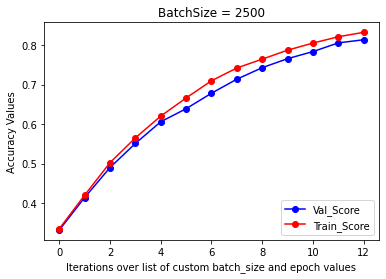

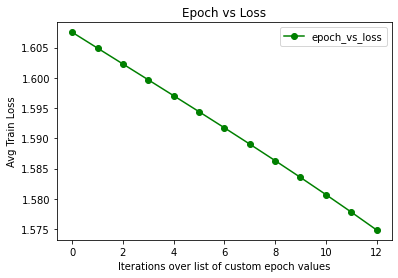

After optimizing the model
Train Accurary: 83.280%
Validation Accurary: 81.400%
Minimum Difference between Train Acc and Validation Acc: 0.0031999999999999806
Index where Minimum Difference between Train Acc and Validation Acc: 0
Max value of validation accurary: 0.814
Index where Max value of validation accurary: 12
It took us 7.974091664998923 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 1.528777
	epoch 2 is finished.
	  avg. train loss: 1.521063
	epoch 4 is finished.
	  avg. train loss: 1.512731
	epoch 10 is finished.
	  avg. train loss: 1.503715
	epoch 20 is finished.
	  avg. train loss: 1.493914
	epoch 25 is finished.
	  avg. train loss: 1.483237
	epoch 50 is finished.
	  avg. train loss: 1.471560
	epoch 100 is finished.
	  avg. train loss: 1.458776
	epoch 125 is finished.
	  avg. train loss: 1.444767
	epoch 250 is finished.
	  avg. train loss: 1.429416
	epoch 625 is finished.
	  avg. train loss: 1.412639
	epoch 1250 is finished.
	  avg. train loss: 1.394348


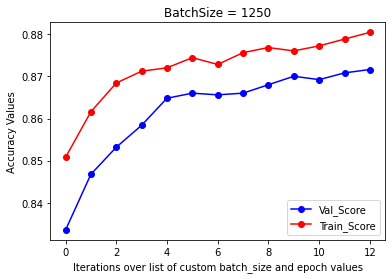

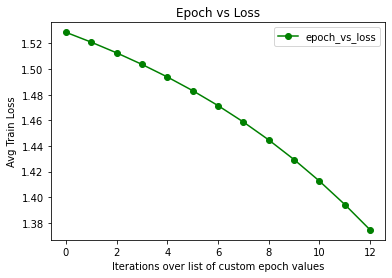

After optimizing the model
Train Accurary: 88.040%
Validation Accurary: 87.160%
Minimum Difference between Train Acc and Validation Acc: 0.006000000000000005
Index where Minimum Difference between Train Acc and Validation Acc: 9
Max value of validation accurary: 0.8716
Index where Max value of validation accurary: 12
It took us 7.742838402000416 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 1.044039
	epoch 2 is finished.
	  avg. train loss: 0.978538
	epoch 4 is finished.
	  avg. train loss: 0.913778
	epoch 10 is finished.
	  avg. train loss: 0.852239
	epoch 20 is finished.
	  avg. train loss: 0.795446
	epoch 25 is finished.
	  avg. train loss: 0.744173
	epoch 50 is finished.
	  avg. train loss: 0.698572
	epoch 100 is finished.
	  avg. train loss: 0.658276
	epoch 125 is finished.
	  avg. train loss: 0.622761
	epoch 250 is finished.
	  avg. train loss: 0.591374
	epoch 625 is finished.
	  avg. train loss: 0.563551
	epoch 1250 is finished.
	  avg. train loss: 0.538745


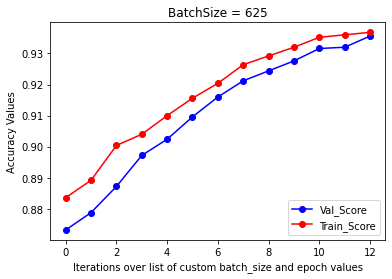

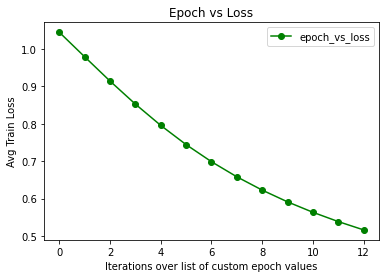

After optimizing the model
Train Accurary: 93.680%
Validation Accurary: 93.560%
Minimum Difference between Train Acc and Validation Acc: 0.0011999999999999789
Index where Minimum Difference between Train Acc and Validation Acc: 12
Max value of validation accurary: 0.9356
Index where Max value of validation accurary: 12
It took us 7.650147399999696 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.229041
	epoch 2 is finished.
	  avg. train loss: 0.217037
	epoch 4 is finished.
	  avg. train loss: 0.207017
	epoch 10 is finished.
	  avg. train loss: 0.198357
	epoch 20 is finished.
	  avg. train loss: 0.190777
	epoch 25 is finished.
	  avg. train loss: 0.184047
	epoch 50 is finished.
	  avg. train loss: 0.177984
	epoch 100 is finished.
	  avg. train loss: 0.172469
	epoch 125 is finished.
	  avg. train loss: 0.167445
	epoch 250 is finished.
	  avg. train loss: 0.162790
	epoch 625 is finished.
	  avg. train loss: 0.158431
	epoch 1250 is finished.
	  avg. train loss: 0.15436

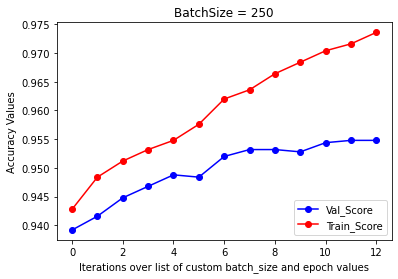

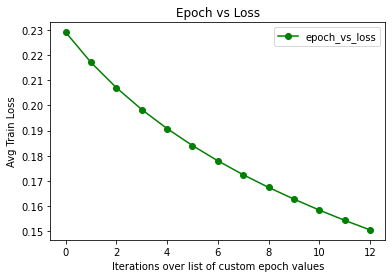

After optimizing the model
Train Accurary: 97.360%
Validation Accurary: 95.480%
Minimum Difference between Train Acc and Validation Acc: 0.0035999999999999366
Index where Minimum Difference between Train Acc and Validation Acc: 0
Max value of validation accurary: 0.9548
Index where Max value of validation accurary: 11
It took us 8.531800359000044 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.099785
	epoch 2 is finished.
	  avg. train loss: 0.095782
	epoch 4 is finished.
	  avg. train loss: 0.091989
	epoch 10 is finished.
	  avg. train loss: 0.088564
	epoch 20 is finished.
	  avg. train loss: 0.085317
	epoch 25 is finished.
	  avg. train loss: 0.082292
	epoch 50 is finished.
	  avg. train loss: 0.079452
	epoch 100 is finished.
	  avg. train loss: 0.076753
	epoch 125 is finished.
	  avg. train loss: 0.074184
	epoch 250 is finished.
	  avg. train loss: 0.071769
	epoch 625 is finished.
	  avg. train loss: 0.069479
	epoch 1250 is finished.
	  avg. train loss: 0.067322

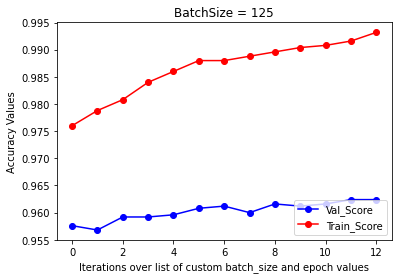

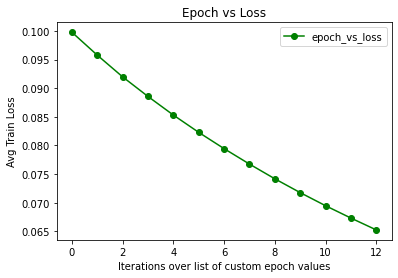

After optimizing the model
Train Accurary: 99.320%
Validation Accurary: 96.240%
Minimum Difference between Train Acc and Validation Acc: 0.018399999999999972
Index where Minimum Difference between Train Acc and Validation Acc: 0
Max value of validation accurary: 0.9624
Index where Max value of validation accurary: 11
It took us 9.801911636001023 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.038087
	epoch 2 is finished.
	  avg. train loss: 0.036435
	epoch 4 is finished.
	  avg. train loss: 0.035009
	epoch 10 is finished.
	  avg. train loss: 0.033643
	epoch 20 is finished.
	  avg. train loss: 0.032379
	epoch 25 is finished.
	  avg. train loss: 0.031199
	epoch 50 is finished.
	  avg. train loss: 0.030084
	epoch 100 is finished.
	  avg. train loss: 0.029037
	epoch 125 is finished.
	  avg. train loss: 0.028053
	epoch 250 is finished.
	  avg. train loss: 0.027124
	epoch 625 is finished.
	  avg. train loss: 0.026240
	epoch 1250 is finished.
	  avg. train loss: 0.025409


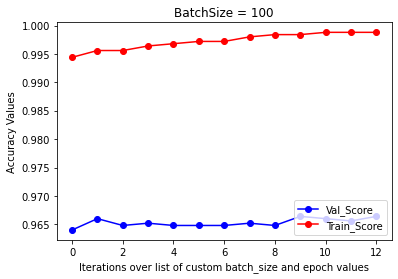

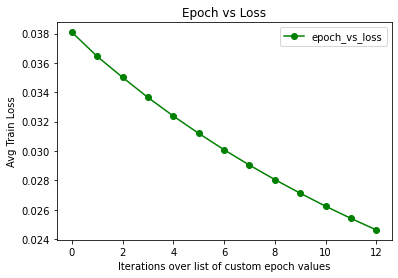

After optimizing the model
Train Accurary: 99.880%
Validation Accurary: 96.640%
Minimum Difference between Train Acc and Validation Acc: 0.02960000000000007
Index where Minimum Difference between Train Acc and Validation Acc: 1
Max value of validation accurary: 0.9664
Index where Max value of validation accurary: 9
It took us 12.939442720000443 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.014566
	epoch 2 is finished.
	  avg. train loss: 0.013580
	epoch 4 is finished.
	  avg. train loss: 0.012818
	epoch 10 is finished.
	  avg. train loss: 0.012098
	epoch 20 is finished.
	  avg. train loss: 0.011435
	epoch 25 is finished.
	  avg. train loss: 0.010858
	epoch 50 is finished.
	  avg. train loss: 0.010327
	epoch 100 is finished.
	  avg. train loss: 0.009857
	epoch 125 is finished.
	  avg. train loss: 0.009422
	epoch 250 is finished.
	  avg. train loss: 0.009030
	epoch 625 is finished.
	  avg. train loss: 0.008665
	epoch 1250 is finished.
	  avg. train loss: 0.008335
	

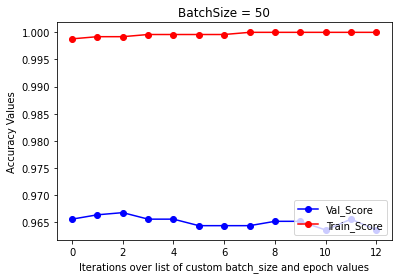

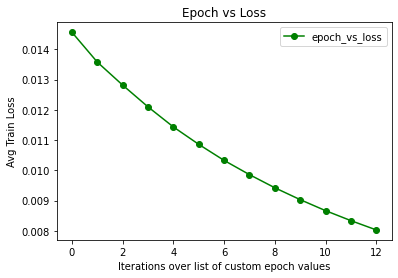

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.360%
Minimum Difference between Train Acc and Validation Acc: 0.032399999999999984
Index where Minimum Difference between Train Acc and Validation Acc: 2
Max value of validation accurary: 0.9668
Index where Max value of validation accurary: 2
It took us 13.491368003000389 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.004207
	epoch 2 is finished.
	  avg. train loss: 0.003920
	epoch 4 is finished.
	  avg. train loss: 0.003692
	epoch 10 is finished.
	  avg. train loss: 0.003494
	epoch 20 is finished.
	  avg. train loss: 0.003318
	epoch 25 is finished.
	  avg. train loss: 0.003163
	epoch 50 is finished.
	  avg. train loss: 0.003022
	epoch 100 is finished.
	  avg. train loss: 0.002895
	epoch 125 is finished.
	  avg. train loss: 0.002779
	epoch 250 is finished.
	  avg. train loss: 0.002674
	epoch 625 is finished.
	  avg. train loss: 0.002577
	epoch 1250 is finished.
	  avg. train loss: 0.002488

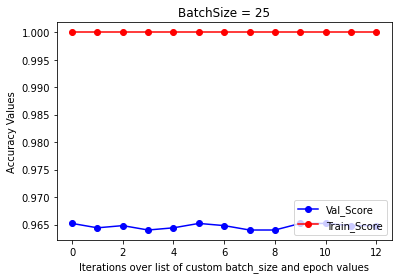

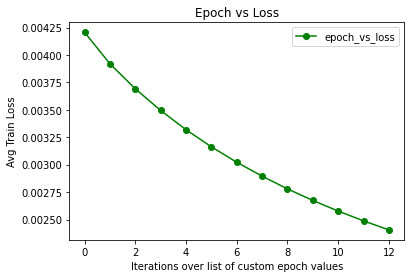

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.480%
Minimum Difference between Train Acc and Validation Acc: 0.03480000000000005
Index where Minimum Difference between Train Acc and Validation Acc: 0
Max value of validation accurary: 0.9652
Index where Max value of validation accurary: 0
It took us 18.793432659000246 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.001343
	epoch 2 is finished.
	  avg. train loss: 0.001296
	epoch 4 is finished.
	  avg. train loss: 0.001252
	epoch 10 is finished.
	  avg. train loss: 0.001212
	epoch 20 is finished.
	  avg. train loss: 0.001175
	epoch 25 is finished.
	  avg. train loss: 0.001141
	epoch 50 is finished.
	  avg. train loss: 0.001109
	epoch 100 is finished.
	  avg. train loss: 0.001080
	epoch 125 is finished.
	  avg. train loss: 0.001052
	epoch 250 is finished.
	  avg. train loss: 0.001026
	epoch 625 is finished.
	  avg. train loss: 0.001001
	epoch 1250 is finished.
	  avg. train loss: 0.000977


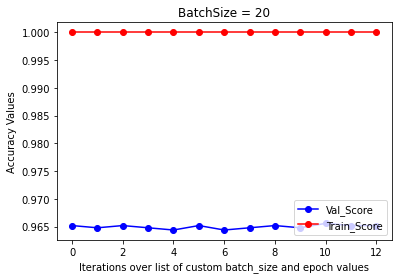

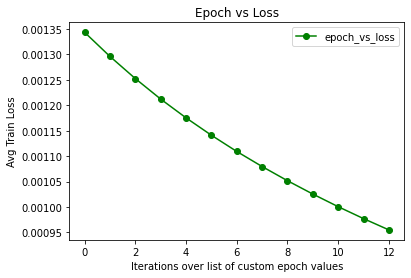

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.520%
Minimum Difference between Train Acc and Validation Acc: 0.034399999999999986
Index where Minimum Difference between Train Acc and Validation Acc: 10
Max value of validation accurary: 0.9656
Index where Max value of validation accurary: 10
It took us 21.578997575001267 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.000669
	epoch 2 is finished.
	  avg. train loss: 0.000643
	epoch 4 is finished.
	  avg. train loss: 0.000618
	epoch 10 is finished.
	  avg. train loss: 0.000596
	epoch 20 is finished.
	  avg. train loss: 0.000576
	epoch 25 is finished.
	  avg. train loss: 0.000557
	epoch 50 is finished.
	  avg. train loss: 0.000540
	epoch 100 is finished.
	  avg. train loss: 0.000524
	epoch 125 is finished.
	  avg. train loss: 0.000508
	epoch 250 is finished.
	  avg. train loss: 0.000494
	epoch 625 is finished.
	  avg. train loss: 0.000481
	epoch 1250 is finished.
	  avg. train loss: 0.0004

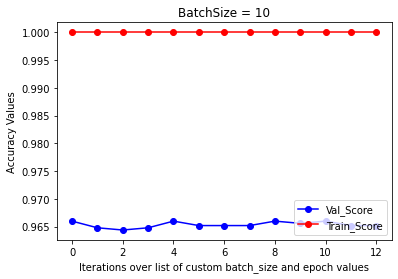

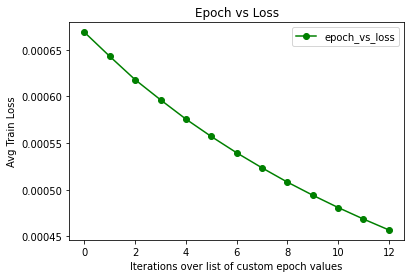

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.520%
Minimum Difference between Train Acc and Validation Acc: 0.03400000000000003
Index where Minimum Difference between Train Acc and Validation Acc: 0
Max value of validation accurary: 0.966
Index where Max value of validation accurary: 0
It took us 34.83561892999933 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.000310
	epoch 2 is finished.
	  avg. train loss: 0.000294
	epoch 4 is finished.
	  avg. train loss: 0.000279
	epoch 10 is finished.
	  avg. train loss: 0.000266
	epoch 20 is finished.
	  avg. train loss: 0.000255
	epoch 25 is finished.
	  avg. train loss: 0.000244
	epoch 50 is finished.
	  avg. train loss: 0.000235
	epoch 100 is finished.
	  avg. train loss: 0.000226
	epoch 125 is finished.
	  avg. train loss: 0.000218
	epoch 250 is finished.
	  avg. train loss: 0.000211
	epoch 625 is finished.
	  avg. train loss: 0.000204
	epoch 1250 is finished.
	  avg. train loss: 0.000198
	e

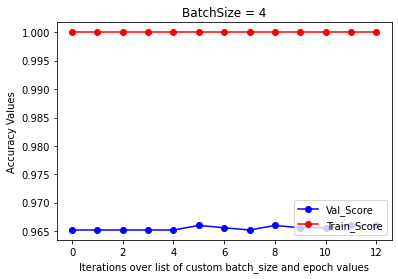

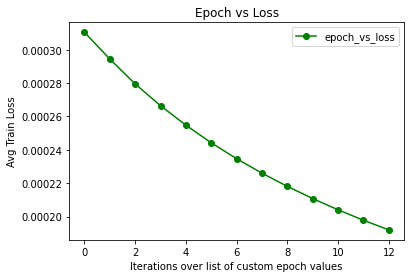

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.600%
Minimum Difference between Train Acc and Validation Acc: 0.03400000000000003
Index where Minimum Difference between Train Acc and Validation Acc: 5
Max value of validation accurary: 0.966
Index where Max value of validation accurary: 5
It took us 78.66453404099957 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.000118
	epoch 2 is finished.
	  avg. train loss: 0.000112
	epoch 4 is finished.
	  avg. train loss: 0.000107
	epoch 10 is finished.
	  avg. train loss: 0.000103
	epoch 20 is finished.
	  avg. train loss: 0.000099
	epoch 25 is finished.
	  avg. train loss: 0.000095
	epoch 50 is finished.
	  avg. train loss: 0.000091
	epoch 100 is finished.
	  avg. train loss: 0.000088
	epoch 125 is finished.
	  avg. train loss: 0.000085
	epoch 250 is finished.
	  avg. train loss: 0.000083
	epoch 625 is finished.
	  avg. train loss: 0.000080
	epoch 1250 is finished.
	  avg. train loss: 0.000078
	e

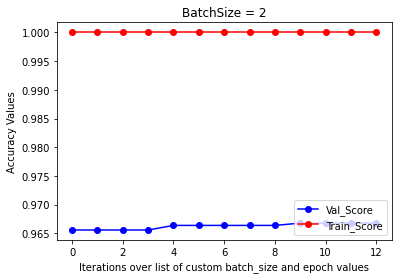

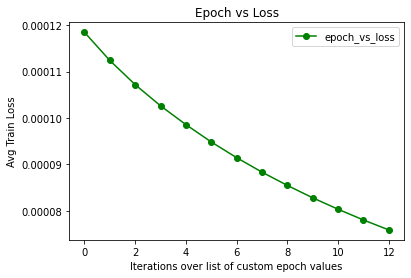

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.680%
Minimum Difference between Train Acc and Validation Acc: 0.03320000000000001
Index where Minimum Difference between Train Acc and Validation Acc: 9
Max value of validation accurary: 0.9668
Index where Max value of validation accurary: 9
It took us 150.63842608599953 seconds to run this loop
	epoch 1 is finished.
	  avg. train loss: 0.000048
	epoch 2 is finished.
	  avg. train loss: 0.000046
	epoch 4 is finished.
	  avg. train loss: 0.000044
	epoch 10 is finished.
	  avg. train loss: 0.000042
	epoch 20 is finished.
	  avg. train loss: 0.000041
	epoch 25 is finished.
	  avg. train loss: 0.000039
	epoch 50 is finished.
	  avg. train loss: 0.000038
	epoch 100 is finished.
	  avg. train loss: 0.000037
	epoch 125 is finished.
	  avg. train loss: 0.000036
	epoch 250 is finished.
	  avg. train loss: 0.000035
	epoch 625 is finished.
	  avg. train loss: 0.000034
	epoch 1250 is finished.
	  avg. train loss: 0.000033


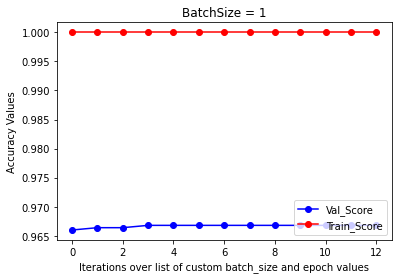

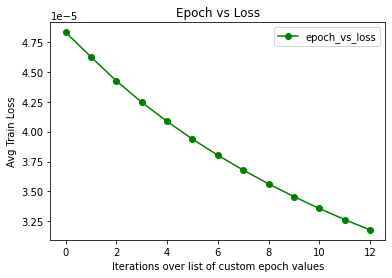

After optimizing the model
Train Accurary: 100.000%
Validation Accurary: 96.680%
Minimum Difference between Train Acc and Validation Acc: 0.03320000000000001
Index where Minimum Difference between Train Acc and Validation Acc: 3
Max value of validation accurary: 0.9668
Index where Max value of validation accurary: 3
It took us 270.6900630729997 seconds to run this loop


In [21]:
batch_epoch_train_net()